# COVID19 testing

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Usual-Python-set-up" data-toc-modified-id="Usual-Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usual Python set-up</a></span></li><li><span><a href="#Grab-some-testing-data" data-toc-modified-id="Grab-some-testing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grab some testing data</a></span></li><li><span><a href="#Plot-national-test-positivity" data-toc-modified-id="Plot-national-test-positivity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot national test positivity</a></span></li></ul></div>

## Usual Python set-up

In [1]:
# imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
from pathlib import Path
import datetime

In [2]:
# local imports
sys.path.append(r'../bin')
from plotstuff import negative_correct_daily

In [3]:
# display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
# plotting stuff
plt.style.use('ggplot')

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

CHART_DIRECTORY_BASE = '../charts'
Path(CHART_DIRECTORY_BASE).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY = CHART_DIRECTORY_BASE + '/!Test-'

## Grab some testing data

In [5]:
data = pd.read_csv(
    'https://github.com/owid/covid-19-data/'+
    'raw/master/public/data/owid-covid-data.csv', 
    header=0)
data = data[data['total_tests'].notna()]
print(f'Data to: {data.date.sort_values().iloc[-1]}')

Data to: 2020-09-07


In [6]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

In [7]:
data.location.unique()

array(['Argentina', 'Australia', 'Austria', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada',
       'Chile', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Czech Republic', 'Denmark', 'Ecuador', 'El Salvador',
       'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'Germany', 'Ghana',
       'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Maldives', 'Malta', 'Mexico', 'Morocco',
       'Mozambique', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand',
       'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
       'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore',
       'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain',
       'Sri Lanka', 'Sw

## Plot national test positivity

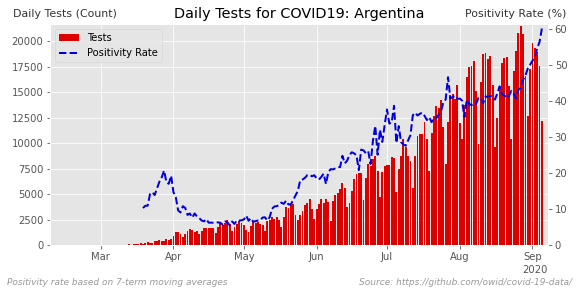

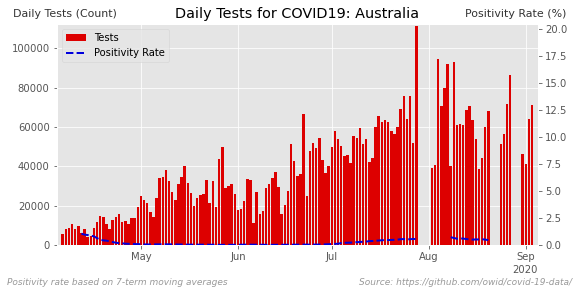

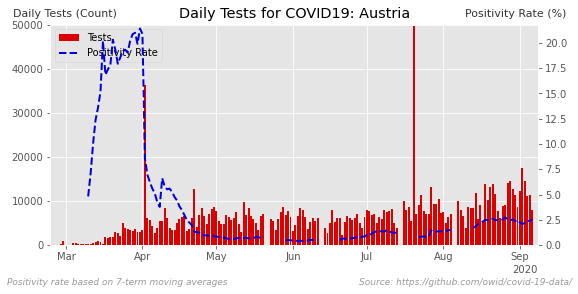

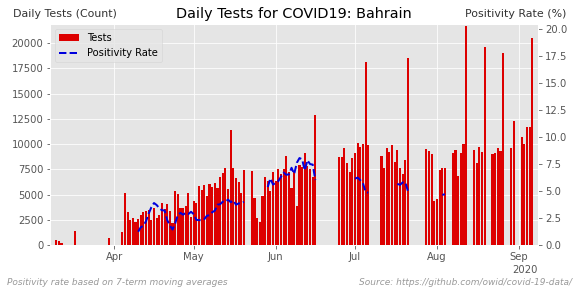

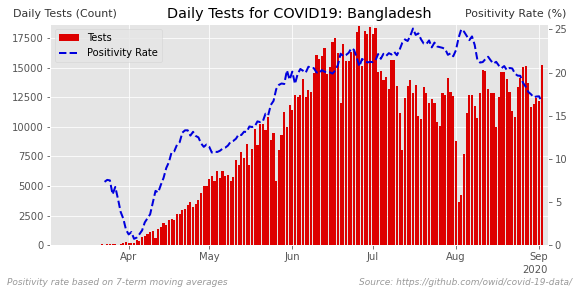

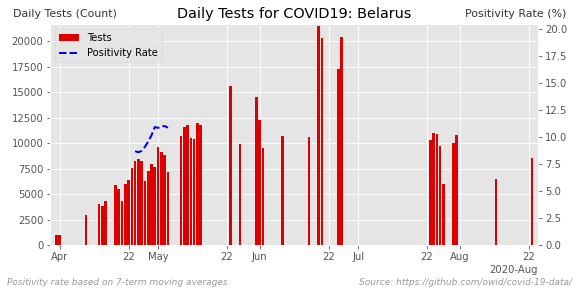

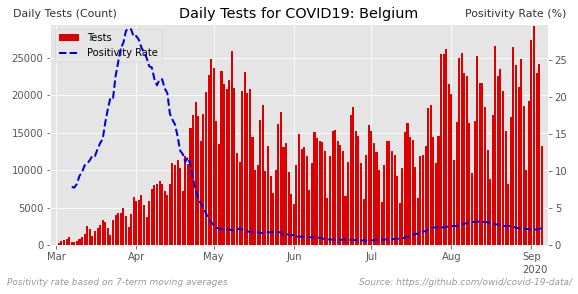

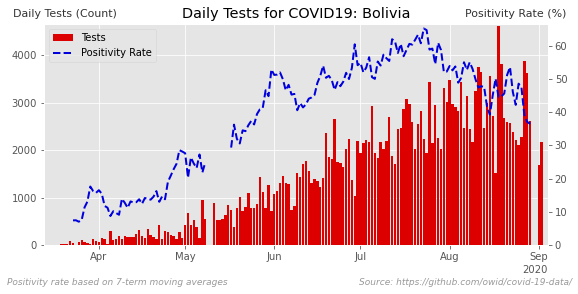

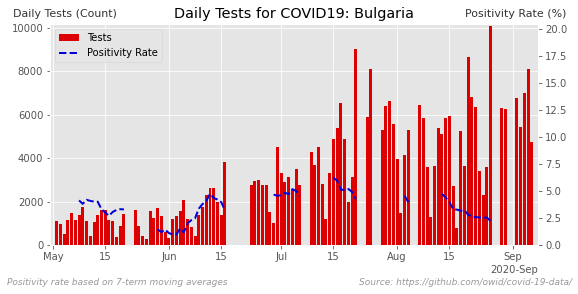

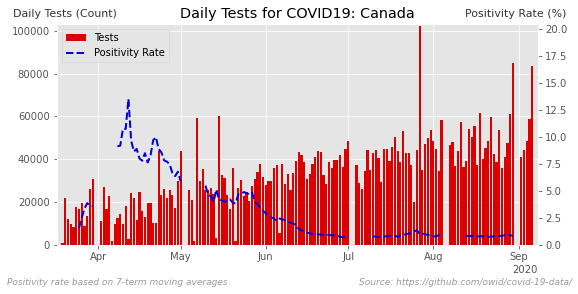

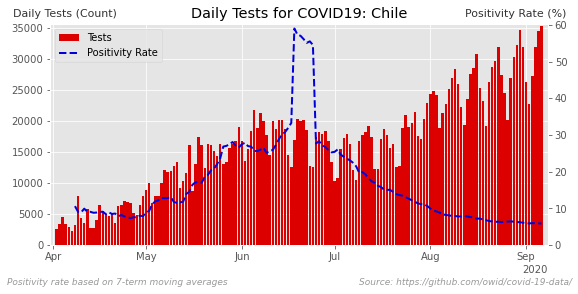

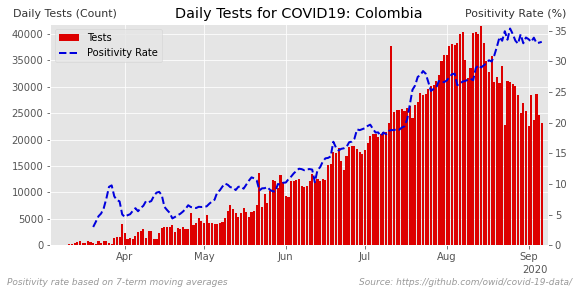

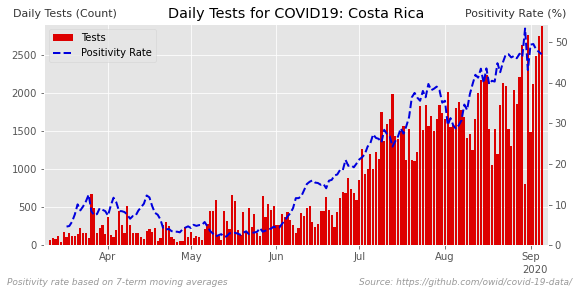

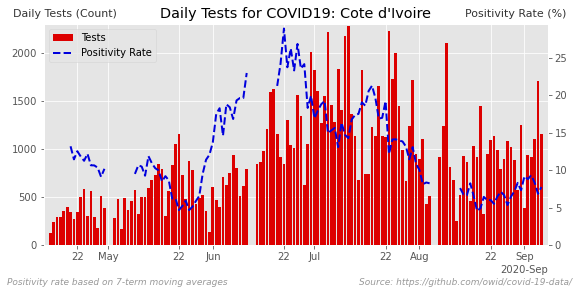

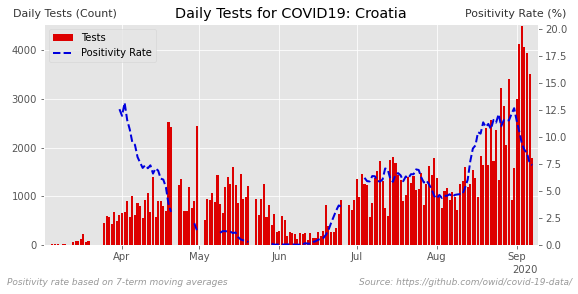

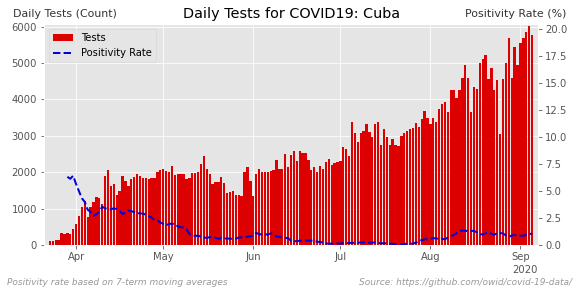

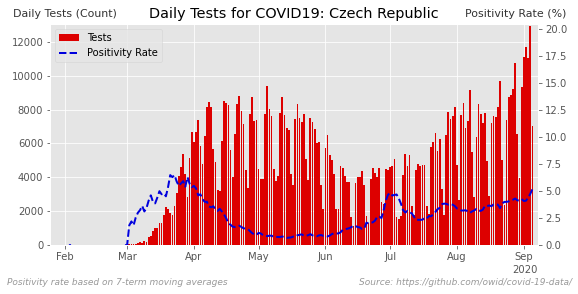

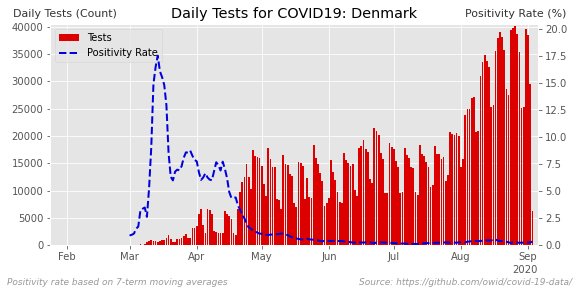

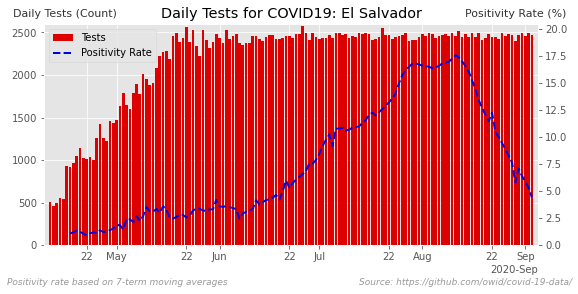

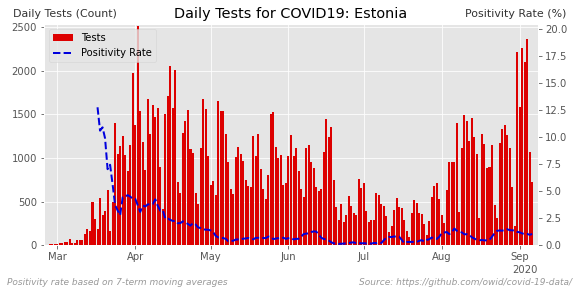

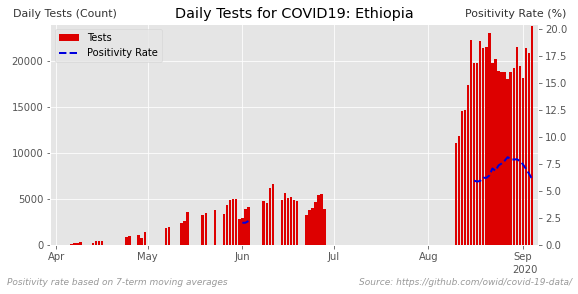

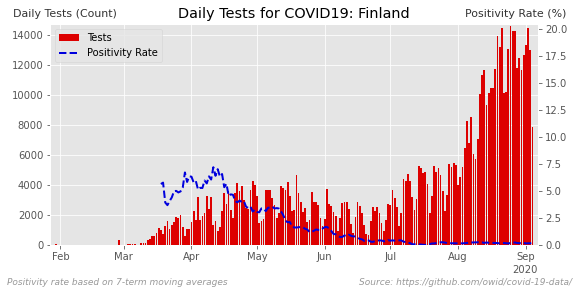

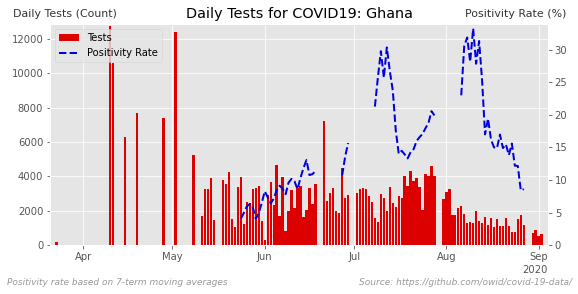

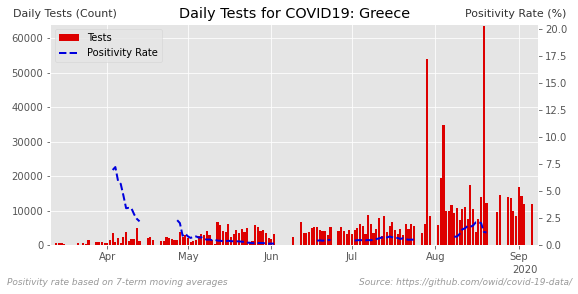

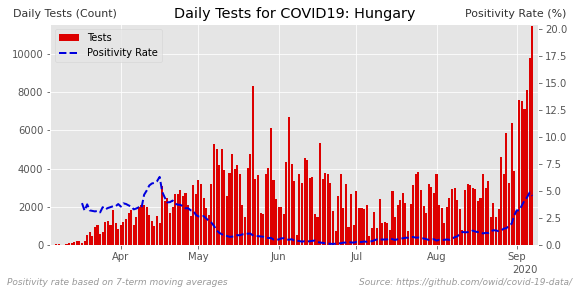

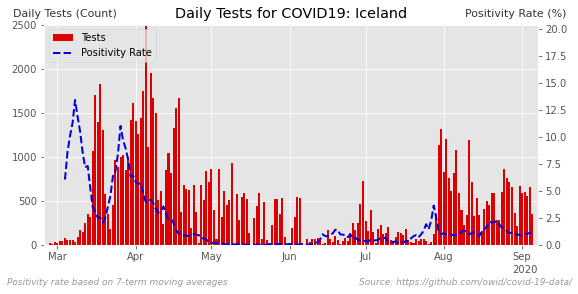

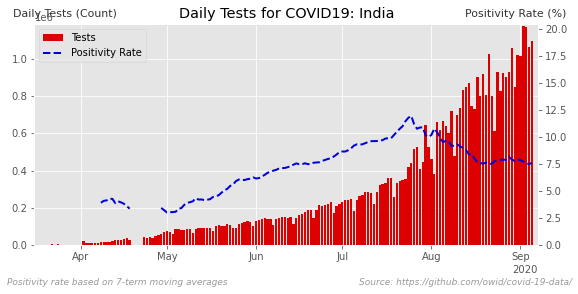

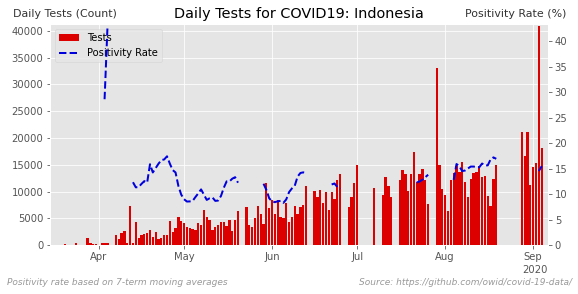

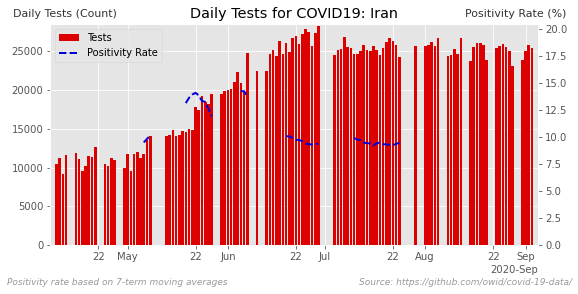

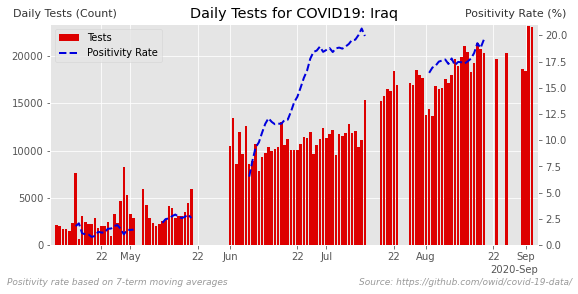

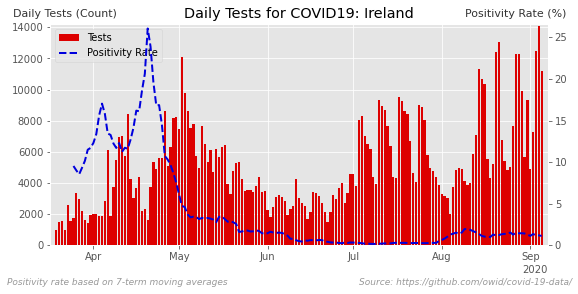

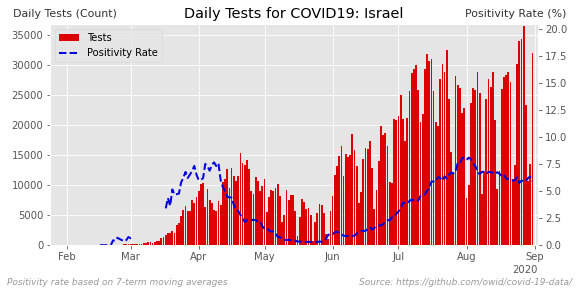

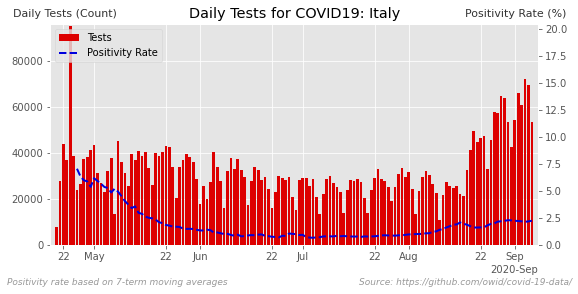

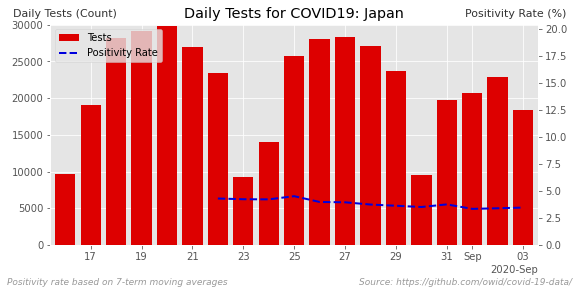

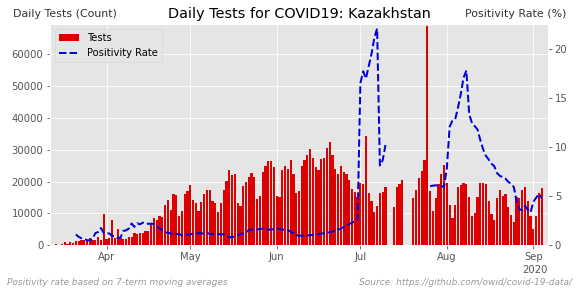

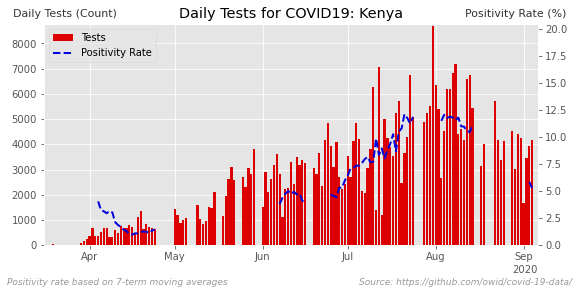

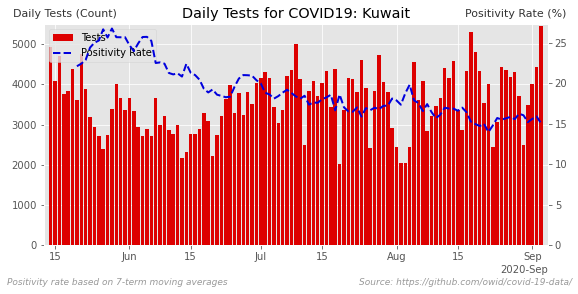

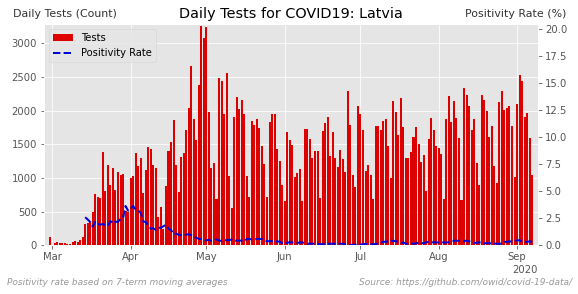

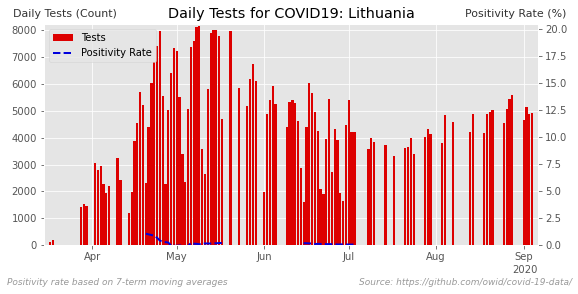

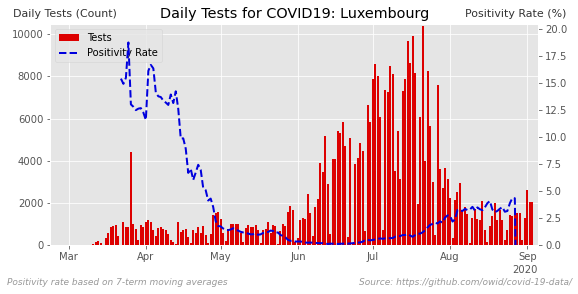

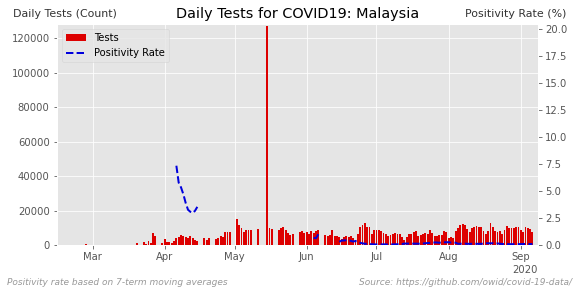

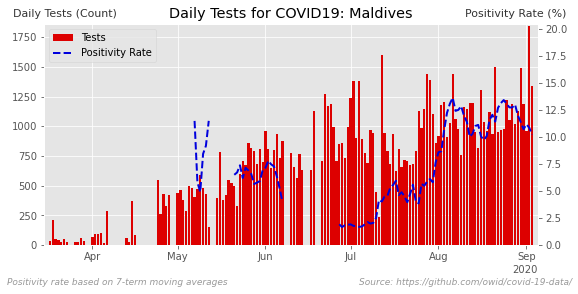

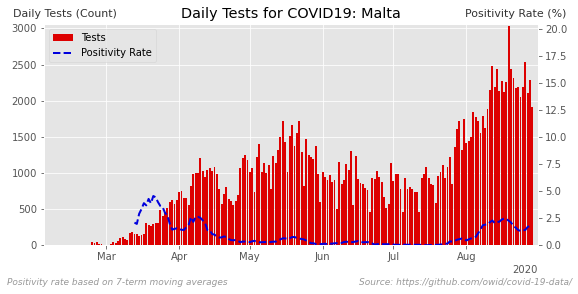

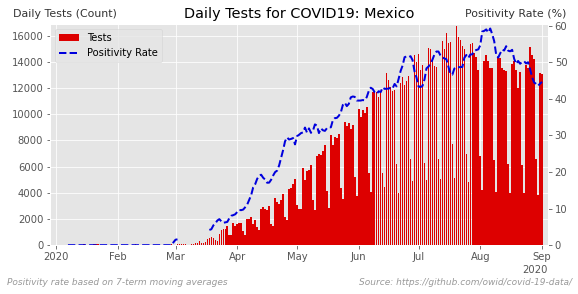

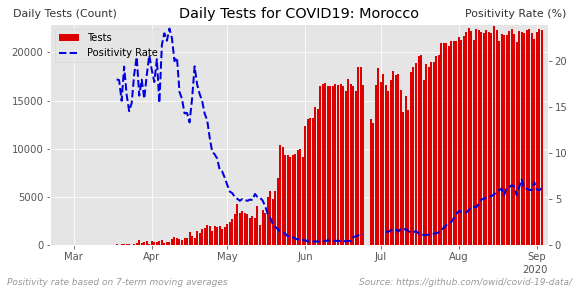

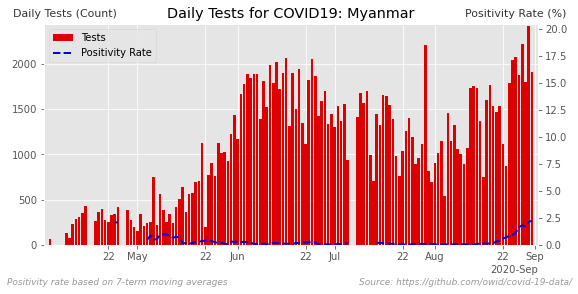

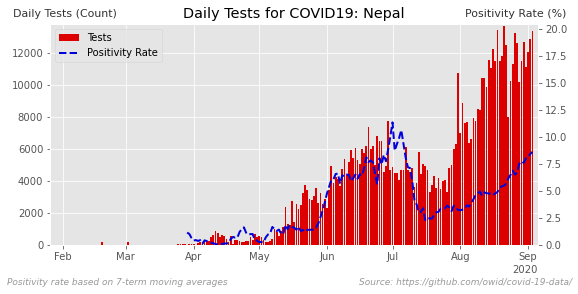

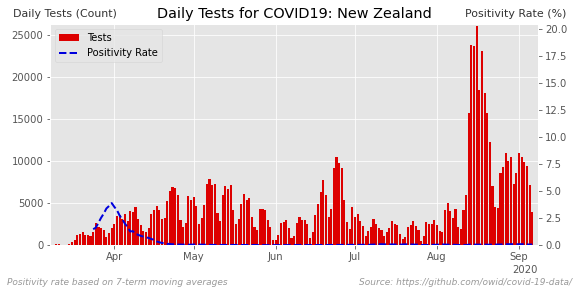

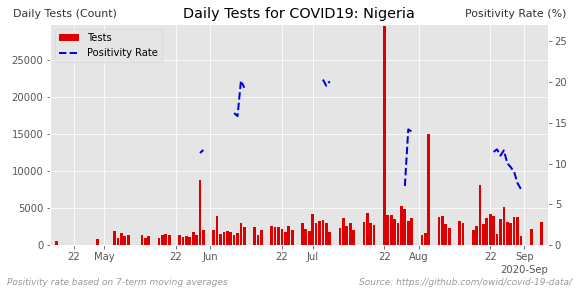

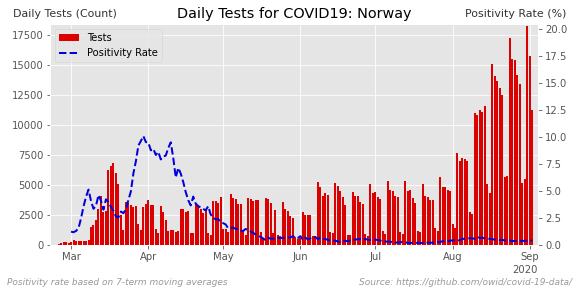

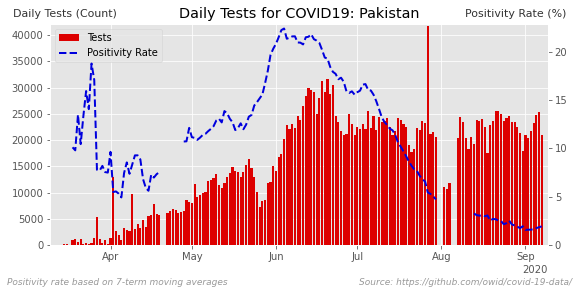

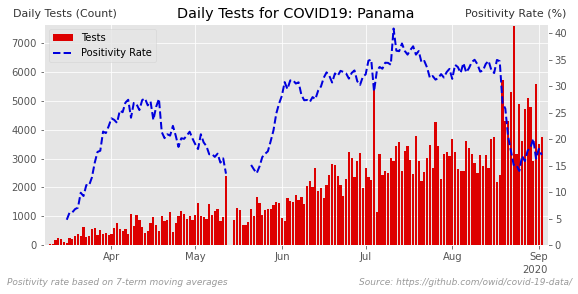

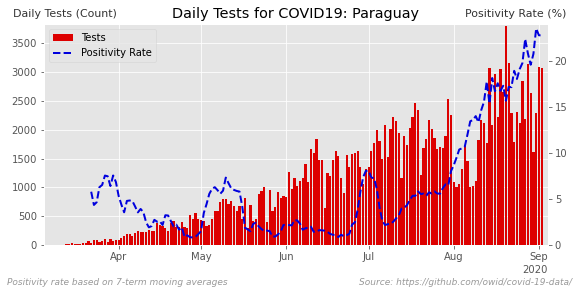

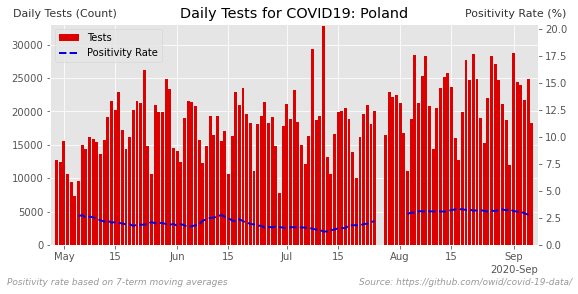

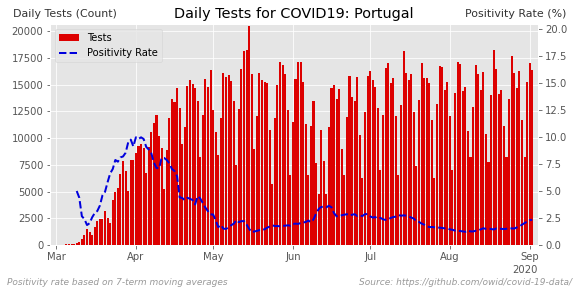

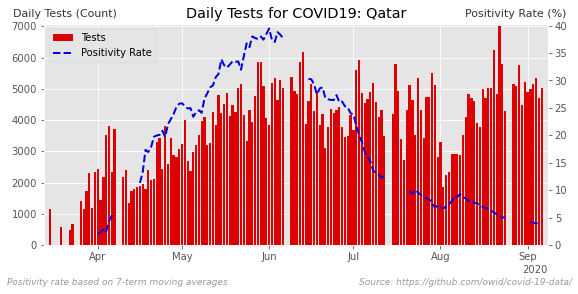

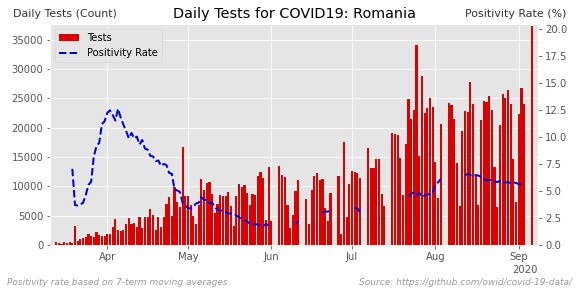

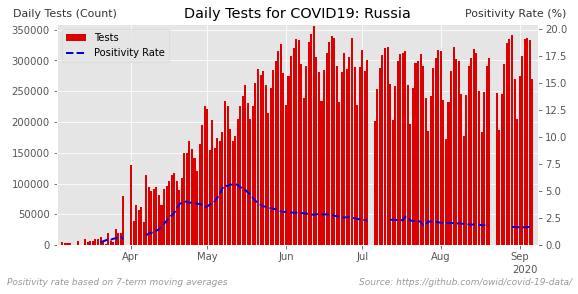

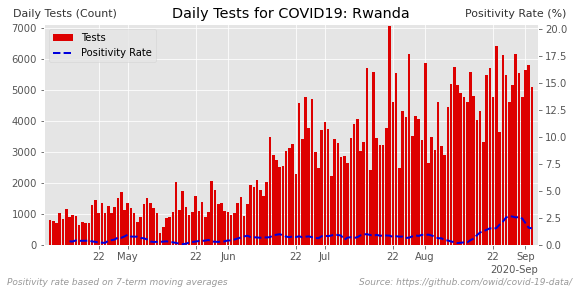

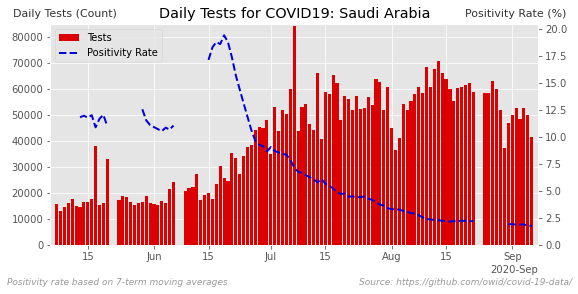

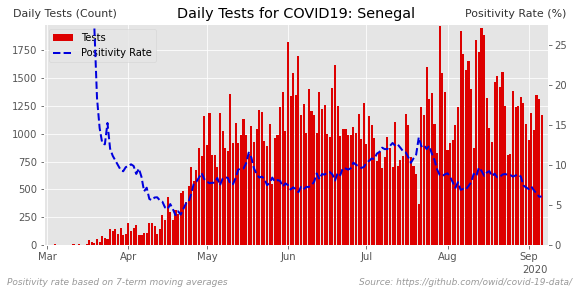

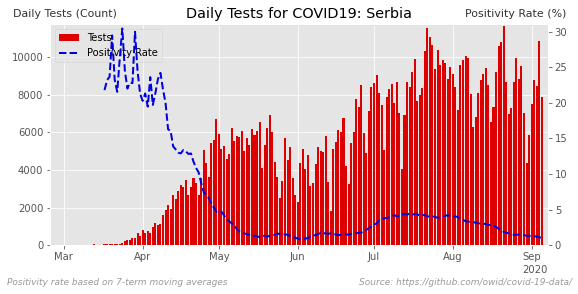

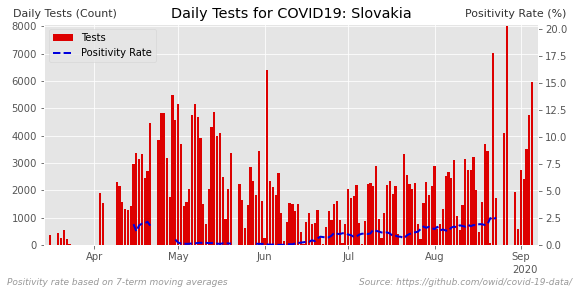

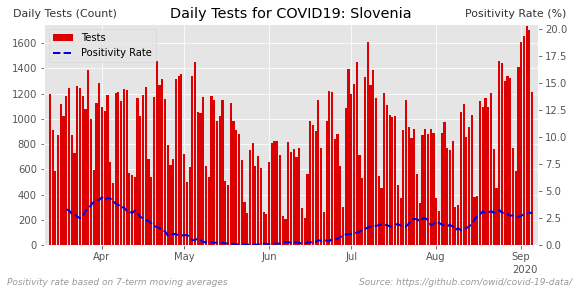

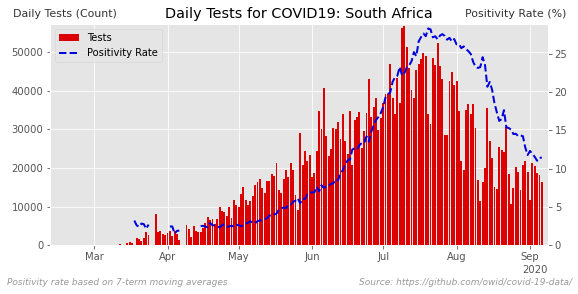

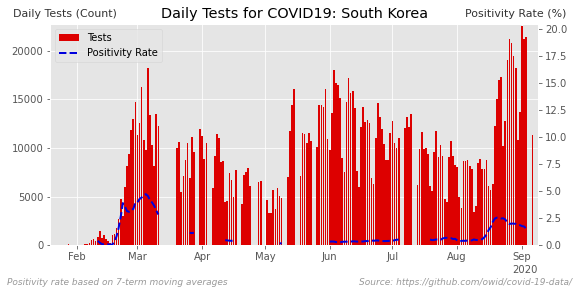

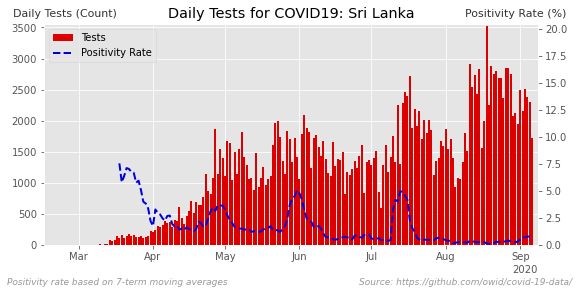

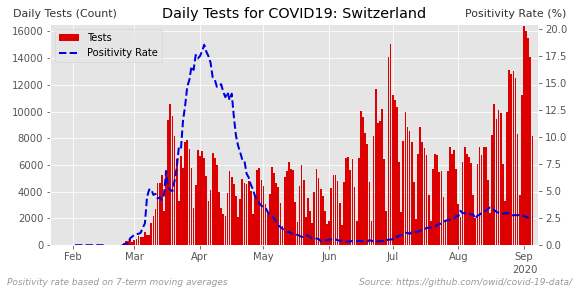

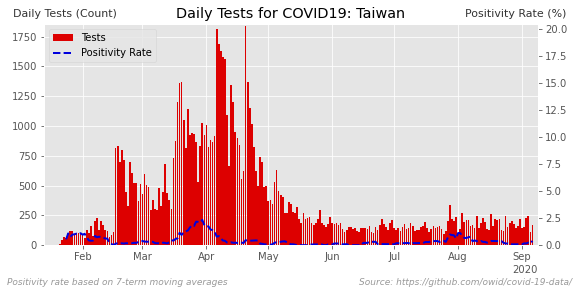

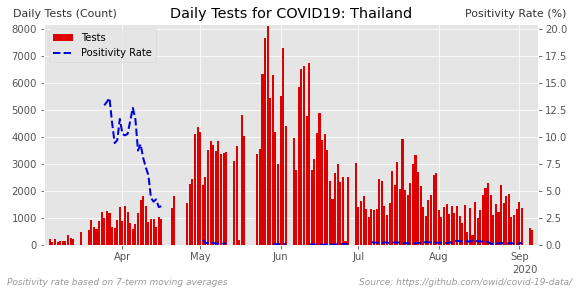

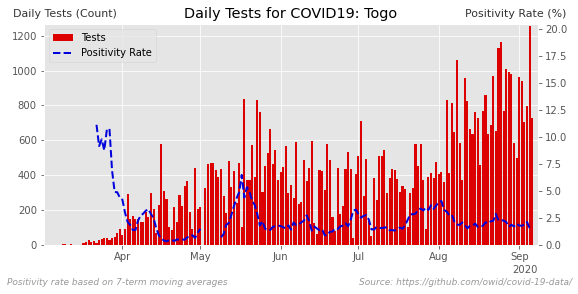

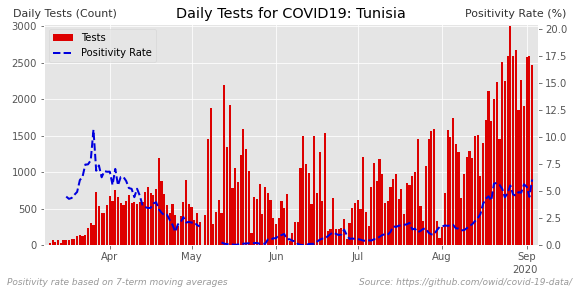

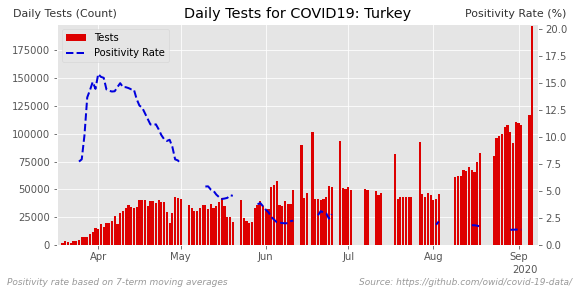

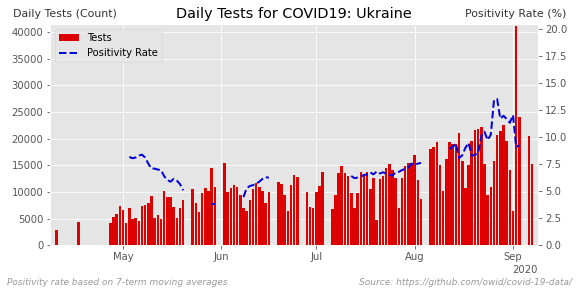

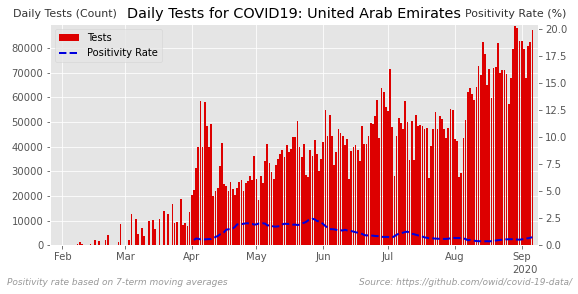

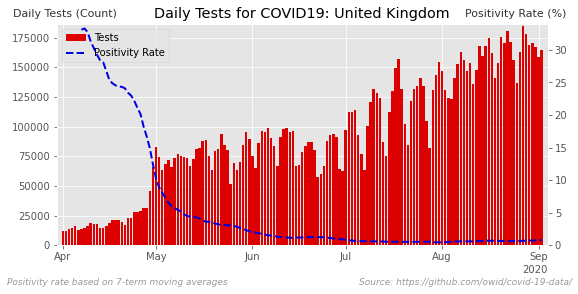

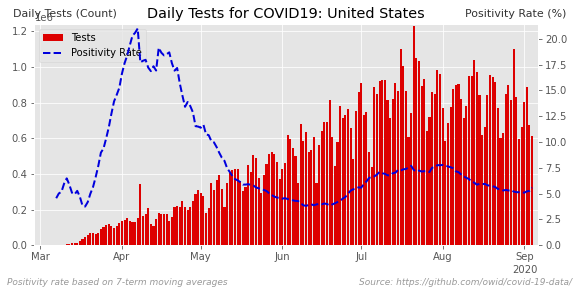

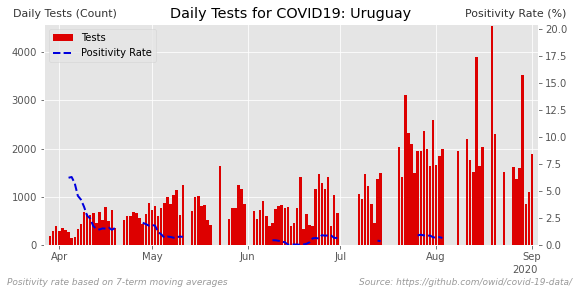

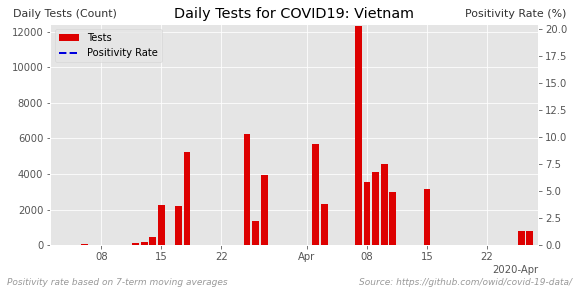

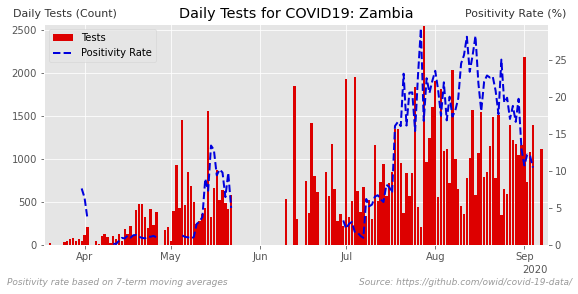

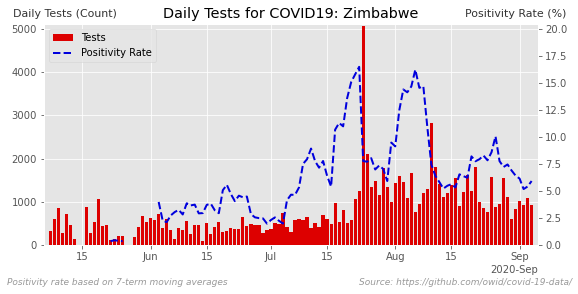

In [8]:
# grab data - apply a three day rolling average
MA = 7
new_tests_orig = data.pivot(index='date', columns='location', 
                values='new_tests')
new_tests_orig.index = pd.DatetimeIndex(new_tests_orig.index)

new_tests = new_tests_orig.rolling(MA).mean() 

new_cases = data.pivot(index='date', columns='location', 
                values='new_cases').rolling(MA).mean()
new_cases.index = pd.DatetimeIndex(new_cases.index)

# calculate a rate
pos = new_cases.div(new_tests) * 100

for name in pos.columns:

    tests = new_tests_orig[name]
    if tests.min() < 0:
        continue
    from_date = tests.first_valid_index()
    if not from_date:
        continue
    tests = tests[tests.index >= from_date]
    rate = pos[name]
    if rate.isna().all():
        continue
    rate = rate[rate.index >= from_date]
    
    #print(tests.index.dtype, rate.index.dtype)
    fig, ax = plt.subplots()
    ax.xaxis_date()
    axr = ax.twinx()
    ax.bar(tests.index, tests.to_list(), color='#dd0000', label='Tests')
    axr.plot(rate.index, rate.to_list(), color='#0000dd', lw=2.0, ls='--', label='Positivity Rate')
    
    ax.set_title(F'Daily Tests for COVID19: {name}')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    axr.set_ylabel(None)
    ymax = max(20, pos[name].max()) * 1.02
    axr.set_ylim([0, ymax])
    axr.grid(False)

    MARGINS = 0.01
    ax.margins(MARGINS)
    axr.margins(MARGINS)
    
    # put in a legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = axr.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='upper left')
    
    # y-axis labels - the hard way
    lHeight = 0.96
    lInstep = 0.02
    fig.text(1.0-lInstep, lHeight, 'Positivity Rate (%)',
            ha='right', va='top', fontsize=11,
            color='#333333')
    fig.text(lInstep, lHeight, 'Daily Tests (Count)',
            ha='left', va='top', fontsize=11,
            color='#333333')
                
    # wrap-up
    fig.set_size_inches(8, 4)
    fig.text(0.99, 0.01, 
         'Source: https://github.com/owid/covid-19-data/',
         ha='right', va='center', fontsize=9, 
         fontstyle='italic', color='#999999')
    fig.text(0.01, 0.01, 
         f'Positivity rate based on {MA}-term moving averages',
         ha='left', va='center', fontsize=9, 
         fontstyle='italic', color='#999999')

    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY_BASE}/{name}-daily-new-tests.png', dpi=125)
    plt.show() 
    plt.close()